# <b> Exploration of the Dumont & Gutkin model for 68 nodes network (sim.run version) </b>
### <i> Marin Dauguet ~ 9 mar 2021 </i>
***

***
### <b> Objectives </b>
Today, let's see with state variable of interest gives the best results and for which type of BOLD (analyzer or monitor). <br> The monitor is showcasing weird behaviour, let's try with sim.run() instead of a loop for the simulation.
***

In [98]:
# Importing relevant stuff
import numpy as np, time as tm
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-dark')

In [99]:
import os
import scipy
import h5py

In [100]:
from scipy.io import loadmat
from scipy.signal import resample, square

In [101]:
from tvb.simulator.lab import *

In [102]:
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.fmri_balloon as bold

***
### <b> Setting it up </b>
First, we need to load in our empirical data.
***

In [103]:
# Importing connectivity
cfile = np.load('/home/marindauguet/Documents/DATA_BERLIN/conn.npz')
conn = connectivity.Connectivity(
    weights = cfile['weights'], 
    tract_lengths = cfile['lengths'],                                 
    region_labels = cfile['regions'], 
    centres = np.ones(len(cfile['regions']))
)

In [104]:
# Normalizing
conn.weights = conn.weights/np.max(conn.weights)
connSC = conn.weights

***
Now that we have our connectivity set, we can set up the simulation. Let's set a 60 seconds stochastic simulation with noise entering on V_e.
***

In [105]:
# Setting up integration time and simulation length
dt = 0.05
simlen = 1000 * 20

In [106]:
# Setting up the monitors
dt_sampling = 5 # sampling period in ms
mon_tavg = monitors.TemporalAverage(period=dt_sampling)
mon_bold = monitors.Bold(period=2000)
what_to_watch = (mon_tavg, mon_bold)

In [107]:
# Setting up the noise and the coupling
    # Noise
nsigma = .00005
#nsigma = (nsigma**2)/2
nsigma_dgmd = [0, nsigma, 0, 0, 0, 0, 0, 0]
hiss = noise.Additive(nsig=np.array(nsigma_dgmd))
heunint = integrators.HeunStochastic(dt = dt, noise = hiss)
    # Coupling
G = .05
con_coupling = coupling.Scaling(a = np.array(G))

In [108]:
# Setting up the model
dgmd = models.DumontGutkin(
    Delta_e=np.array([2.]),
    Delta_i=np.array([2.]),
    J_ee=np.array([2]),
    J_ei=np.array([15.]),
    J_ie=np.array([15.]),
    J_ii=np.array([0.]),
    I_i=np.array([0.]),
    I_e=np.array([8.75]),
    Gamma=np.array([5.]))

***
### <b> Simulation </b>
***

In [109]:
# Setting up the simulation
sim = simulator.Simulator(model = dgmd,
                          connectivity = conn,
                          conduction_speed = np.inf,
                          coupling = con_coupling,
                          integrator = heunint,
                          monitors = what_to_watch,
                          simulation_length = simlen)
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 76405331-28cf-4223-9a7c-49e90af66e89
coupling,Scaling gid: 03a15cb9-1508-4c94-a010-5a98ea6b5ae9
gid,UUID('579c333f-f265-4d73-aacb-a34c4659a3ab')
initial_conditions,None
integrator,HeunStochastic gid: e6272cfd-08e3-493c-8358-e7e2b10b1f63
model,DumontGutkin gid: e0c7de23-8cce-4f30-8615-30e2ea648988
monitors,"(, )"
simulation_length,20000.0


In [110]:
# Estimated run time of simulation
RUN = sim.runtime(simulation_length = simlen)/4.15
print('estimated runtime is %0.1f seconds.' % RUN)
# Running the simulation
tic = tm.time()
(tavg_time, tavg_data), (bold_time, bold_data) = sim.run()
print('simulation required %0.1f seconds.' % (tm.time()-tic))

estimated runtime is 344.5 seconds.
simulation required 373.8 seconds.


***
### <b> Analyzer </b>
Setting up the BOLD analyzer for r_e
***

In [111]:
    # Creating a Time Series instance
tsr = TimeSeriesRegion(connectivity = conn,
                       data = tavg_data[:,0:1,:,:],
                       time = tavg_time,
                       sample_period = dt_sampling)
tsr.configure()

In [112]:
    # Creating and running the monitor/analyser
bold_model = bold.BalloonModel(time_series = tsr)
bold_analyzer = bold_model.evaluate()
# probably not needed
bold_tsr = TimeSeriesRegion(connectivity = conn,
                            data = bold_analyzer.data, 
                            time = bold_analyzer.time)

  ERROR  Integration time step shouldn't be smaller than the sampling period of the input signal.


/home/marindauguet/anaconda3/envs/py3/lib/python3.9/site-packages/tvb/analyzers/fmri_balloon.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return numpy.array([k1, k2, k3])


***
### <b> Visualization </b>
Let's see for r_e
***

In [113]:
# resample
Nresample = bold_time.shape[0]
databoldt = resample(bold_analyzer.data, Nresample)
timeboldt = resample(bold_analyzer.time, Nresample)

In [114]:
N = len(sim.connectivity.region_labels)

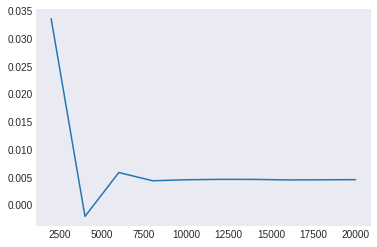

In [115]:
plt.plot(bold_time, bold_data[:, 0, 0, 0])

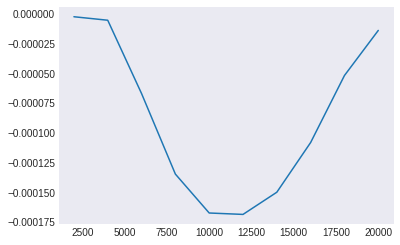

In [116]:
plt.plot(bold_time, databoldt[:, 0, 0, 0])

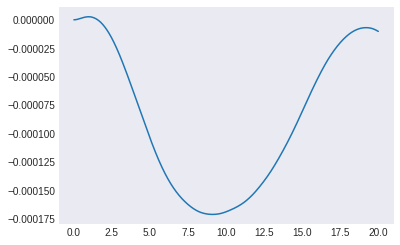

In [117]:
plt.plot(bold_analyzer.time, bold_analyzer.data[:, 0, 0, 0])

nrows = 5
varr = 0 # which variable
fig, axs = plt.subplots(nrows=nrows, sharex=True, figsize=(20,nrows*2))

for i, reg in enumerate(sim.connectivity.region_labels[:N]):
    ax = axs[i]
    ax.plot(bold_time, bold_data[:, varr, i, 0], alpha=0.5, color='red')
    ax.plot(tavg_time, tavg_data[:, varr, i, 0], alpha=0.5, color='blue')
    ax.plot(bold_time, databoldt[:, varr, i, 0], alpha=0.5, color='green')
    ax.set(ylabel=reg)
fig.tight_layout()
plt.show()

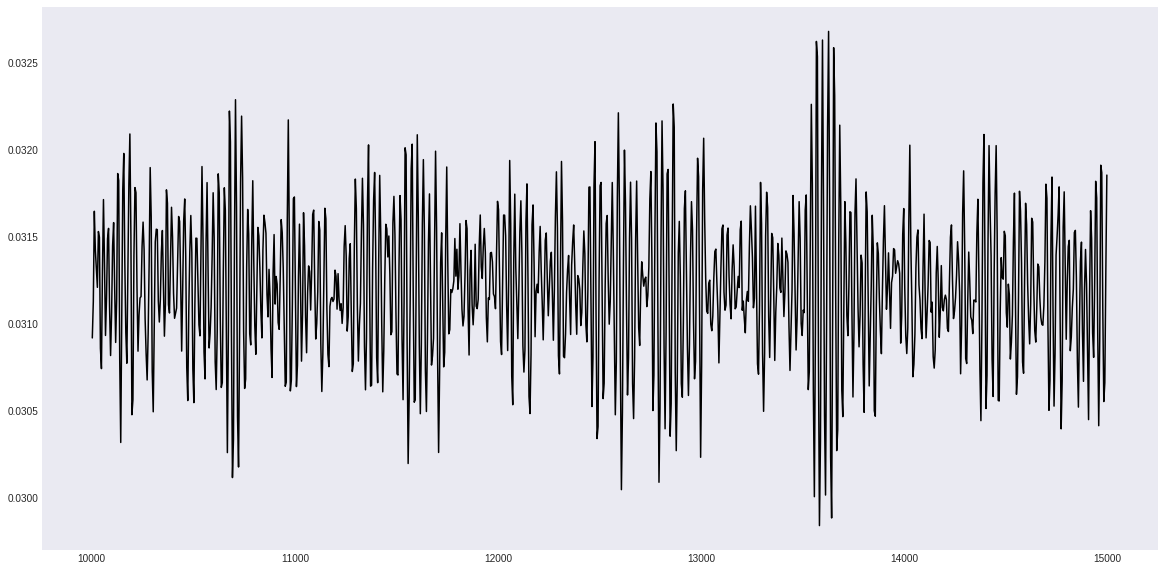

In [118]:
plt.figure(figsize=(20,10))
plt.plot(tavg_time[2000:3000], tavg_data[2000:3000,0,0,0], 'k');

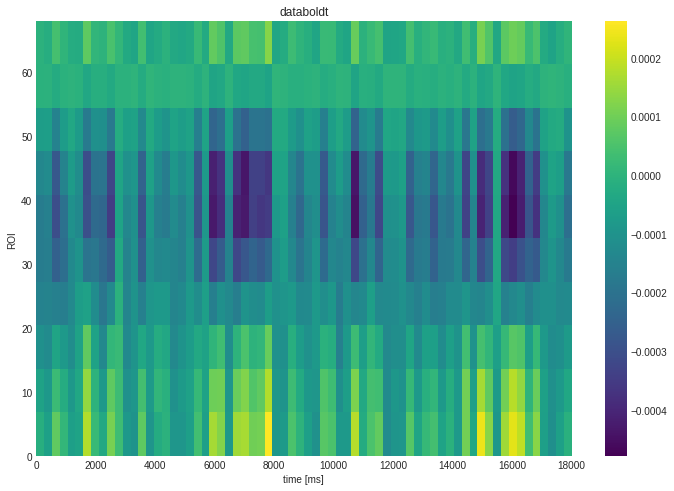

In [190]:
fig, ax = plt.subplots(figsize=(12,8))

t = bold_time[-1] - bold_time[0]
N = databoldt.shape[2]

im = ax.imshow(databoldt[:,0,:,0], extent=[0, t, 0, N], aspect='auto', interpolation='none', cmap='viridis', vmin = np.min(databoldt[:,0,:,0]), vmax = np.max(databoldt[:,0,:,0]))

ax.set(xlabel='time [ms]', ylabel='ROI', title='databoldt')
fig.colorbar(im)

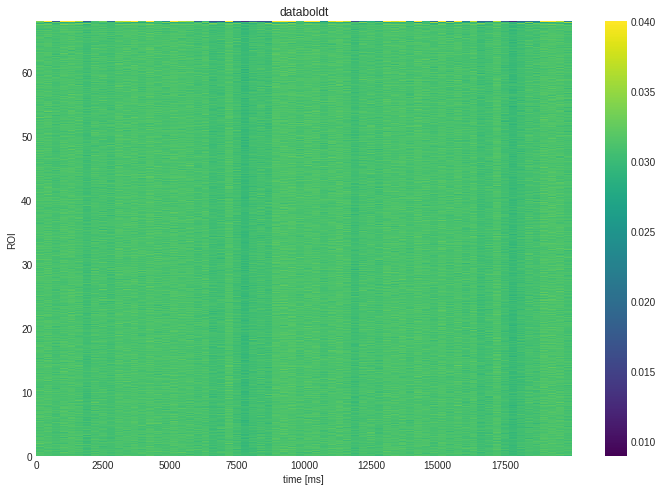

In [201]:
fig, ax = plt.subplots(figsize=(12,8))

t = tavg_time[-1] - tavg_time[0]
N = tavg_data.shape[2]

im = ax.imshow(tavg_data[:,0,:,0], extent=[0, t, 0, N], aspect='auto', interpolation='none', cmap='viridis', vmin = np.min(tavg_data[:,0,:,0]), vmax = 0.04)

ax.set(xlabel='time [ms]', ylabel='ROI', title='databoldt')
fig.colorbar(im)

# Plot FC and FC SC correlation

In [119]:
# calculate FCs
fcsimBOLD = np.corrcoef(bold_data[3:,0,:,0].T)
fcsimTAVGN = np.corrcoef(tavg_data[1000:,0,:,0].T)
fcBOLD_an = np.corrcoef(databoldt[3:,0,:,0].T)

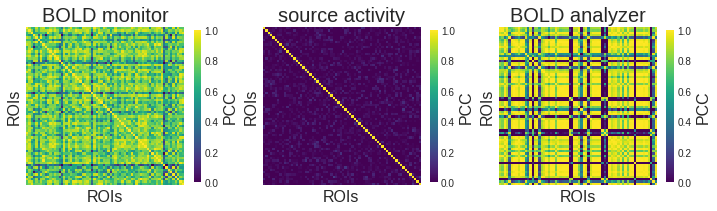

In [120]:
# plot FCs
fig=plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(fcsimBOLD,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('BOLD monitor', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)

plt.subplot(132)
plt.imshow(fcsimTAVGN,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('source activity', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)

plt.subplot(133)
plt.imshow(fcBOLD_an,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('BOLD analyzer', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)


In [121]:
SC = sim.connectivity.weights
fcsimBOLD_triu = np.triu(fcsimBOLD, 1)
fcsimTAVGN_triu = np.triu(fcsimTAVGN, 1)
fcBOLD_an_triu = np.triu(fcBOLD_an, 1)
SCtriu = np.triu(SC, 1)

tavg_pcc = np.corrcoef(SCtriu.ravel(), fcsimBOLD_triu.ravel())[0, 1]
print('BOLDU pcc = {}'.format(round(tavg_pcc,3)))

tavg_pcc = np.corrcoef(SCtriu.ravel(), fcsimTAVGN_triu.ravel())[0, 1]
print('TAVGN pcc = {}'.format(round(tavg_pcc,3)))

tavg_pcc = np.corrcoef(SCtriu.ravel(), fcBOLD_an_triu.ravel())[0, 1]
print('BOLDN pcc = {}'.format(round(tavg_pcc,3)))

BOLDU pcc = 0.186
TAVGN pcc = -0.023
BOLDN pcc = 0.265
